<center>
<img src="../imgs/ods_stickers.jpg">
    
## Открытый курс по машинному обучению
Автор материала: Data Scientist @ Zeptolab, лектор в Центре Математических Финансов МГУ Дмитрий Сергеев. Материал распространяется на условиях лицензии [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/). Можно использовать в любых целях (редактировать, поправлять и брать за основу), кроме коммерческих, но с обязательным упоминанием автора материала.

In [3]:
import sys
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm

import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from scipy.optimize import minimize
# from arch import arch_model

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.dates as mdates
%matplotlib inline

# Линейные и не очень модели на временных рядах

Снова небольшое лирическое отступление. Часто на работе приходится строить модели, руководствуясь одним основополагающим принципом – [*быстро, качественно, недорого*](http://lurkmore.to/Быстро,_качественно,_недорого). Поэтому часть моделей могут банально не подойти для "продакшн-решений", так как либо требуют слишком больших затрат по подготовке данных (например, SARIMA), либо сложно настраиваются (хороший пример – SARIMA), либо требуют частого переобучения на новых данных (опять SARIMA), поэтому зачастую гораздо проще бывает выделить несколько признаков из имеющегося временного ряда и построить по ним обычную линейную регрессию или навесить решаюший лес. Дешево и сердито.

Возможно, этот подход не является значительно подкрепленным теорией, нарушает различные предпосылки, например, условия Гаусса-Маркова, особенно пункт про некоррелированность ошибок, однако на практике нередко выручает и достаточно активно используется в соревнованиях по машинному обучению.

# Извлечение признаков (Feature exctraction)

Помимо стандартных признаков вроде лагов целевой переменной, много информации содержат в себе дата и время. Про извлечение признаков из них уже здорово описано в одной из [предыдущих статей](https://habrahabr.ru/company/ods/blog/325422/#vremennye-ryady-veb-i-prochee) курса.

Добавлю только про еще один вариант кодирования категориальных признаков – кодирование средним. Если не хочется раздувать датасет множеством дамми-переменных, которые могут привести к потере информации о расстоянии, а в вещественном виде возникают противоречивые результаты а-ля "0 часов < 23 часа", то можно закодировать переменную чуть более интерпретируемыми значениями. Естественный вариант – закодировать средним значением целевой переменной. В нашем случае каждый день недели или час дня можно закодировать сооветствующим средним числом игроков, находившихся в этот день недели или час онлайн. При этом важно следить за тем, чтобы расчет среднего значения производился только в рамках тестового датасета (или в рамках текущего наблюдаемого фолда при кросс-валидации), иначе можно ненароком привнести в модель информацию о будущем.

In [4]:
def code_mean(data, cat_feature, real_feature):
    """
    Возвращает словарь, где ключами являются уникальные категории признака cat_feature, 
    а значениями - средние по real_feature
    """
    return dict(data.groupby(cat_feature)[real_feature].mean())

Создадим новый датафрейм и добавим в него час, день недели и выходной в качестве категориальных переменных. Для этого переводим имеющийся в датафрейме индекс в формат `datetime`, и извлекаем из него `hour` и `weekday`.

In [5]:
dataset = pd.read_csv('../data/hour_online.csv', index_col=['Time'], parse_dates=['Time'])

In [7]:
data = pd.DataFrame(dataset.copy())
data.columns = ["y"]

# data.index = data.index.to_datetime()
data["hour"] = data.index.hour
data["weekday"] = data.index.weekday
data['is_weekend'] = data.weekday.isin([5,6])*1
data.head()

,y,hour,weekday,is_weekend
Time,,,,
2017-01-01 00:00:00,34002,0,6,1
2017-01-01 01:00:00,37947,1,6,1
2017-01-01 02:00:00,41517,2,6,1
2017-01-01 03:00:00,44476,3,6,1
2017-01-01 04:00:00,46234,4,6,1


Посмотрим на средние по дням недели

In [8]:
code_mean(data, 'weekday', "y")

{0: 38730.143229166664,
 1: 38632.828125,
 2: 38128.518229166664,
 3: 39519.035135135135,
 4: 41505.15277777778,
 5: 43717.708333333336,
 6: 43392.14360313316}

Помимо перечисленных преобразований для увеличения числа признаков используют и множество других метрик, например, максимальное/минимальное значение, наблюдавшееся в скользящем по ряду окне, медианы, число пиков, взвешенные дисперсии и многое другое. Автоматически этим занимается уже упоминавшаяся в курсе [библиотека tsfresh](https://github.com/blue-yonder/tsfresh).

Для удобства все преобразования можно записать в одну функцию, которая сразу же будет возвращать разбитые на трейн и тест датасеты и целевые переменные.

In [11]:
def prepareData(data, lag_start=5, lag_end=20, test_size=0.15):
    
    data = pd.DataFrame(data.copy())
    data.columns = ["y"]
    
    # считаем индекс в датафрейме, после которого начинается тестовый отрезок
    test_index = int(len(data)*(1-test_size))
    
    # добавляем лаги исходного ряда в качестве признаков
    for i in range(lag_start, lag_end):
        data["lag_{}".format(i)] = data.y.shift(i)
        
    
#     data.index = data.index.to_datetime()
    data["hour"] = data.index.hour
    data["weekday"] = data.index.weekday
    data['is_weekend'] = data.weekday.isin([5,6])*1
    
    # считаем средние только по тренировочной части, чтобы избежать лика
    data['weekday_average'] = list(map(code_mean(data[:test_index], 'weekday', "y").get, data.weekday))
    data["hour_average"] = list(map(code_mean(data[:test_index], 'hour', "y").get, data.hour))

    # выкидываем закодированные средними признаки 
    data.drop(["hour", "weekday"], axis=1, inplace=True)

    data = data.dropna()
    data = data.reset_index(drop=True)
    
    
    # разбиваем весь датасет на тренировочную и тестовую выборку
    X_train = data.loc[:test_index].drop(["y"], axis=1)
    y_train = data.loc[:test_index]["y"]
    X_test = data.loc[test_index:].drop(["y"], axis=1)
    y_test = data.loc[test_index:]["y"]
    
    return X_train, X_test, y_train, y_test

Обучим на получившихся данных простую линейную регрессию. При этом лаги будем брать начиная с двенадцатого, таким образом модель будет способна строить предсказания на 12 часов вперёд, имея фактические наблюдения за предыдущие пол дня

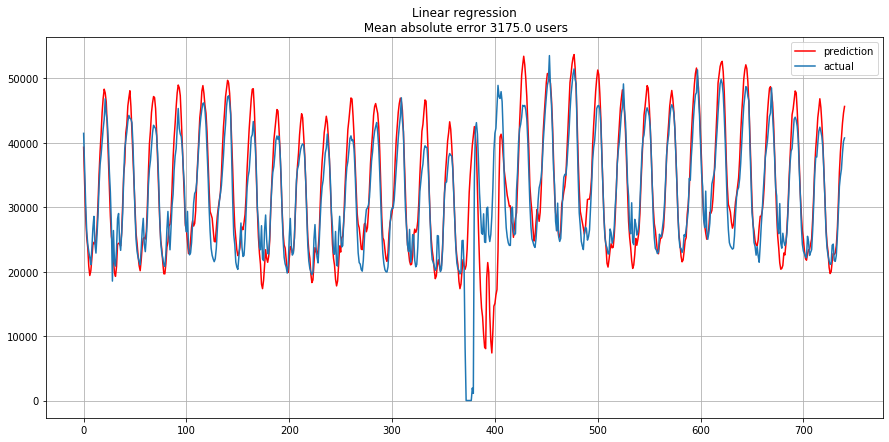

In [12]:
from sklearn.linear_model import LinearRegression

X_train, X_test, y_train, y_test = prepareData(dataset.Users, test_size=0.3, lag_start=12, lag_end=48)
lr = LinearRegression()
lr.fit(X_train, y_train)
prediction = lr.predict(X_test)
plt.figure(figsize=(15, 7))
plt.plot(prediction, "r", label="prediction")
plt.plot(y_test.values, label="actual")
plt.legend(loc="best")
plt.title("Linear regression\n Mean absolute error {} users".format(round(mean_absolute_error(prediction, y_test))))
plt.grid(True);

Получилось достаточно неплохо, даже отбора признаков модель ошибается, в среднем, на 3K пользователей в час, и это учитывая огромный выброс в середине тестового ряда.

Также можно провести оценку модели на кросс-валидации, тому же принципу, что был использован ранее. Для этого воспользуемся функцией (с небольшими модификациями), предложенной в посте [Pythonic Cross Validation on Time Series](http://francescopochetti.com/pythonic-cross-validation-time-series-pandas-scikit-learn/)

In [15]:
def performTimeSeriesCV(X_train, y_train, number_folds, model, metrics):
    print('Size train set: {}'.format(X_train.shape))
    
    k = int(np.floor(float(X_train.shape[0]) / number_folds))
    print('Size of each fold: {}'.format(k))

    errors = np.zeros(number_folds-1)

    # loop from the first 2 folds to the total number of folds    
    for i in range(2, number_folds + 1):
        print()
        split = float(i-1)/i
        print('Splitting the first ' + str(i) + ' chunks at ' + str(i-1) + '/' + str(i) )

        X = X_train[:(k*i)]
        y = y_train[:(k*i)]
        print('Size of train + test: {}'.format(X.shape)) # the size of the dataframe is going to be k*i

        index = int(np.floor(X.shape[0] * split))
        
        # folds used to train the model        
        X_trainFolds = X[:index]        
        y_trainFolds = y[:index]
        
        # fold used to test the model
        X_testFold = X[(index + 1):]
        y_testFold = y[(index + 1):]
        
        model.fit(X_trainFolds, y_trainFolds)
        errors[i-2] = metrics(model.predict(X_testFold), y_testFold)

    
    # the function returns the mean of the errors on the n-1 folds    
    return errors, errors.mean()

In [16]:
performTimeSeriesCV(X_train, y_train, 5, lr, mean_absolute_error)

Size train set: (1838, 39)
Size of each fold: 367

Splitting the first 2 chunks at 1/2
Size of train + test: (734, 39)

Splitting the first 3 chunks at 2/3
Size of train + test: (1101, 39)

Splitting the first 4 chunks at 3/4
Size of train + test: (1468, 39)

Splitting the first 5 chunks at 4/5
Size of train + test: (1835, 39)


(array([ 2070.19187064, 10777.65922789,  2613.27289175,  2991.59173575]),
 4613.178931508971)

На 5 фолдах получили среднюю абсолютную ошибку в 4.6 K пользователей, достаточно близко к оценке качества, полученной на тестовом датасете.

Почему бы теперь не попробовать XGBoost
<img src="https://habrastorage.org/files/754/a9a/26e/754a9a26e59648de9fe2487241a27c43.jpg"/>

In [56]:
# sys.path.append('/Users/dmitrys/xgboost/python-package/')
import xgboost as xgb

def XGB_forecast(data, lag_start=5, lag_end=20, test_size=0.15, scale=1.96):
    
    # исходные данные
    X_train, X_test, y_train, y_test = prepareData(dataset.Users, lag_start, lag_end, test_size)
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X_test)
    
    # задаём параметры
    params = {
        'objective': 'reg:linear',
        'booster':'gblinear'
    }
    trees = 1000
    
    # прогоняем на кросс-валидации с метрикой rmse
    cv = xgb.cv(params, dtrain, metrics = ('rmse'), verbose_eval=False, nfold=10, show_stdv=False, num_boost_round=trees)
    
    # обучаем xgboost с оптимальным числом деревьев, подобранным на кросс-валидации
    bst = xgb.train(params, dtrain, num_boost_round=cv['test-rmse-mean'].argmin())
    
    # можно построить кривые валидации
    #cv.plot(y=['test-mae-mean', 'train-mae-mean'])
    
    # запоминаем ошибку на кросс-валидации
    deviation = cv.loc[cv['test-rmse-mean'].argmin()]["test-rmse-mean"]
    
    # посмотрим, как модель вела себя на тренировочном отрезке ряда
    prediction_train = bst.predict(dtrain)
    plt.figure(figsize=(15, 5))
    plt.plot(prediction_train)
    plt.plot(y_train)
    plt.axis('tight')
    plt.grid(True)
    
    # и на тестовом
    prediction_test = bst.predict(dtest)
    lower = prediction_test-scale*deviation
    upper = prediction_test+scale*deviation

    Anomalies = np.array([np.NaN]*len(y_test))
    Anomalies[y_test<lower] = y_test[y_test<lower]

    plt.figure(figsize=(15, 5))
    plt.plot(prediction_test, label="prediction")
    plt.plot(lower, "r--", label="upper bond / lower bond")
    plt.plot(upper, "r--")
    plt.plot(list(y_test), label="y_test")
    plt.plot(Anomalies, "ro", markersize=10)
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("XGBoost Mean absolute error {} users".format(round(mean_absolute_error(prediction_test, y_test))))
    plt.grid(True)
    plt.legend()

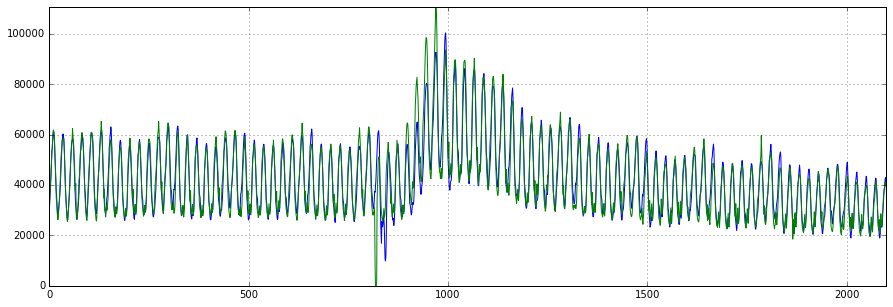

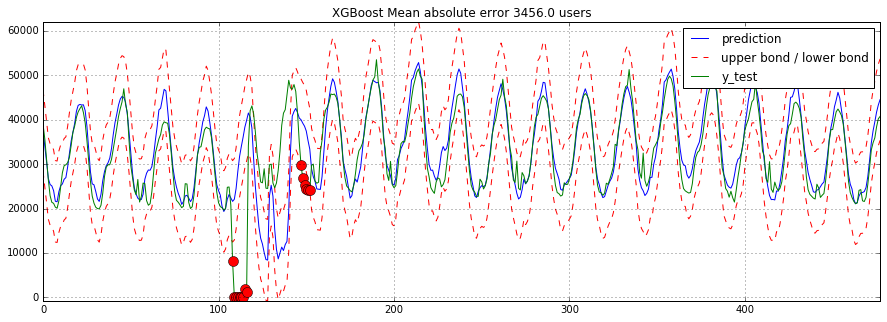

In [57]:
XGB_forecast(dataset, test_size=0.2, lag_start=12, lag_end=48)

Те же 3 K пользователей в средней абсолютной ошибке, и неплохо пойманные аномалии на тестовом датасете. Конечно, чтобы уменьшить ошибку, еще можно повозиться с параметрами, настроить при необходимости регуляризацию, отобрать признаки, понять, на сколько лагов нужно уходить вглубь истории и т.д. 

# Заключение

Мы познакомились с разными методами и подходами к анализу и прогнозированию временных рядов. К сожалению, или к счастью, серебряной пули для решения такого рода задач пока не появилось. Методы, разработанные в 60-е годы прошлого века, (а некоторые и в начале 19-го), по-прежнему пользуются популярностью наравне с неразобранными в рамках данной статьи LSTM или RNN. Отчасти это связано с тем, что задача прогнозирования, как и любая другая задача, возникающая в процессе работы с данными - во многом творческая и уж точно исследовательская. Несмотря на обилие формальных метрик качества и способов оценки параметров, для каждого временного ряда часто приходится подбирать и пробовать что-то своё. Не последнюю роль играет и баланс между качеством и трудозатратами. Не раз уже упоминавшаяся здесь SARIMA-модель хотя и демонстрирует выдающиеся результаты при должной настройке, может потребовать не одного часа ~~танцев с бубном~~ манипуляций с рядом, в то время как простенькую линейную регрессию можно соорудить за 10 минут, получив при этом более-менее сравнимые результаты.

# Полезные ресурсы

- [Онлайн учебник](https://people.duke.edu/~rnau/411home.htm) курса по продвинутому статистическому прогнозированию университета Duke - разобраны всевозможные сглаживания, линейные модели и ARIMA модели 
- Статья [Comparison of ARIMA and Random Forest time series models for prediction of avian influenza H5N1 outbreaks](https://bmcbioinformatics.biomedcentral.com/articles/10.1186/1471-2105-15-276) - одна из немногих, где активно защищается позиция случайного леса в задачах по прогнозированию временных рядов
- Статья [Time Series Analysis (TSA) in Python - Linear Models to GARCH](http://www.blackarbs.com/blog/time-series-analysis-in-python-linear-models-to-garch/11/1/2016) семействе моделей ARIMA и их применении для моделирования финансовых показателей (Brian Christopher)